In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import Image
from IPython import display
import numpy as np
from scipy.spatial import Delaunay
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib widget


In [3]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
players_background = pd.read_csv("BigDataBowl2023/data2023/players.csv", index_col='nflId')
player_stats = pd.read_csv("BigDataBowl2023/merged_df.csv")
median_stats = pd.read_csv("BigDataBowl2023/all_pos_df.csv", index_col=0)
#player_stats.head()
#w1data.head()

In [4]:
def collect_game_info(weekdf, playId, saved=False):
    
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
    return playdf

In [5]:
collect_game_info(w1data, 90,True)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
377637,2021091204,90,41251.0,1,2021-09-12T17:07:23.400,2.0,SF,left,73.56,15.30,1.04,0.97,0.11,74.46,34.20,None
377676,2021091204,90,41256.0,1,2021-09-12T17:07:23.400,1.0,SF,left,60.02,26.23,0.05,0.57,0.00,84.21,159.84,None
378222,2021091204,90,47791.0,1,2021-09-12T17:07:23.400,88.0,DET,left,76.60,18.80,1.84,1.94,0.19,283.77,343.82,None
377949,2021091204,90,44947.0,1,2021-09-12T17:07:23.400,30.0,DET,left,82.96,25.96,0.00,0.00,0.00,283.66,100.51,None
378339,2021091204,90,48455.0,1,2021-09-12T17:07:23.400,67.0,DET,left,76.40,29.12,0.00,0.00,0.00,258.99,88.78,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377870,2021091204,90,43290.0,39,2021-09-12T17:07:27.200,16.0,DET,left,85.00,33.71,5.86,1.46,0.59,339.16,8.39,None
377792,2021091204,90,42389.0,39,2021-09-12T17:07:27.200,3.0,SF,left,81.03,13.03,1.04,2.80,0.09,346.29,321.94,None
378377,2021091204,90,48455.0,39,2021-09-12T17:07:27.200,67.0,DET,left,76.72,23.42,1.97,1.31,0.20,230.09,333.73,None
378182,2021091204,90,46424.0,39,2021-09-12T17:07:27.200,45.0,DET,left,83.15,17.48,1.11,0.78,0.11,248.55,129.75,None


In [6]:
def delaunay(current_pos):
    stacked_pos = np.stack((np.vstack(current_pos[0]), np.vstack(current_pos[1])), axis=0)
    delaunay_triangulation1 = Delaunay(stacked_pos[0])
    delaunay_triangulation2 = Delaunay(stacked_pos[1])
    return delaunay_triangulation1, delaunay_triangulation2, stacked_pos

Simulated
Animating...


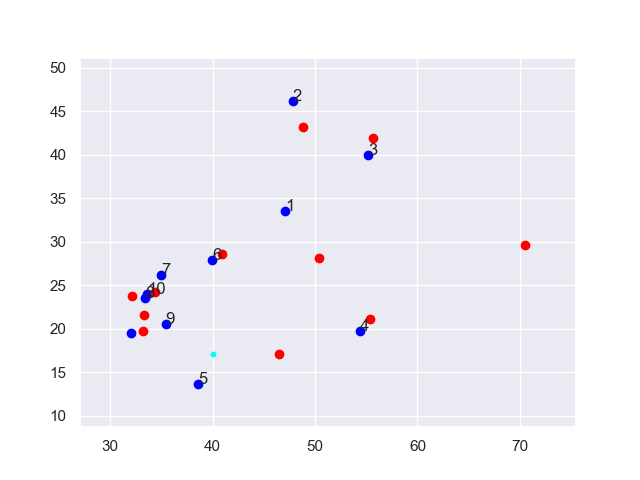

In [7]:
class Simulation:
    def __init__(self, weekdf, madden_df, median_df, players_background, playId):
        play = collect_game_info(weekdf, playId)

        # players.csv
        self.players_background = players_background
        # Make the madden nflId int and set as index
        madden_df.loc[:, 'nflId'] = madden_df['nflId'].astype('int64')
        madden_df = madden_df.set_index('nflId')
        self.madden_df = madden_df
        self.median_df = median_df

        self.play_df = play.dropna()
        self.ball_df = play[play['team'] == 'football']

        # convert frameId to integer values
        self.play_df.loc[:, 'frameId'] = self.play_df['frameId'].astype('int')
        # Do the same for nflIds
        self.play_df.loc[:, 'nflId'] = self.play_df['nflId'].astype('int64')

        # Reindex to players and frames (these are what we're plotting over)
        self.player_df = self.play_df.set_index(['nflId', 'frameId'])
        self.ball_df = self.ball_df.set_index(['frameId'])

        # Stuff for plotting
        self.num_frames = len(self.play_df['frameId'].unique())
        self.num_players = len(self.play_df['jerseyNumber'].unique())
        self.teams = self.player_df['team'].unique()
        self.xrange = (self.player_df['x'].min()-5, self.player_df['x'].max()+5)
        self.yrange = (self.player_df['y'].min()-5, self.player_df['y'].max()+5)
        self.fig = plt.figure()
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)
        self.frames = None


    def model_frame(self, i):
        """
        Calculates the score of the receivers on the attacking team for a single frame in the play dataframe
        TODO: ADD VORONOI/DELAUNAY
        :param i: frame number, starts at zero and ends at (self.num_frames - 1)
        :return: DataFrame of the
        """


        # Slice the player_df at frame i+1 (i is 1 behind the frameId)
        # Get the players dataframe for just this frame, removing the index of frame with .droplevel(-1)
        idx = pd.IndexSlice
        player_frame_df = self.player_df.loc[idx[:, i+1], :].droplevel(-1)
        ball_frame_df = self.ball_df.loc[i+1].to_frame().transpose() # the hatred towards pandas I have in this instant is unquantifiable with words
        ball_frame_df['nflId'] = 'football'
        ball_frame_df.set_index('nflId', inplace=True)

        # Find the nflId of the QB (theres probably a better way to do this but idk it)
        for nflId, player in player_frame_df.iterrows():
            pos = self.players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]


        # Sort the players into attackers and defenders
        attackers = player_frame_df[player_frame_df['team']==qb_team]
        defenders = player_frame_df[player_frame_df['team']!=qb_team]

        receiver_ratings = {'nflId':[], 'receiver rating':[]}

        qb_stats = self.madden_df.loc[qb_Id]

        throw_score = qb_stats['Throw On The Run'] + qb_stats['Throw Under Pressure'] + qb_stats['Throw Power'] # !!!


        for nflId, player in attackers.iterrows():
            # We dont want to add the qb as a genuine receiver (maybe he could be? need to think about this though)
            if nflId != qb_Id:
                player_position = self.players_background.loc[nflId]['officialPosition']

                if nflId in self.madden_df.index:
                    player_stats = self.madden_df.loc[nflId]
                else:
                    player_stats = self.median_df.loc[player_position]

                x, y = player.loc[['x', 'y']]
                # Calculate the distance between the qb and the player

                # Calculate the scaling from the distance of the throw
                dist = np.sqrt((qbx-x)**2+(qby-y)**2)
                if dist >= 20:
                    throw_score += qb_stats['Throw Acc Deep']
                elif dist >=10:
                    throw_score += qb_stats['Throw Acc Mid']
                else:
                    throw_score += qb_stats['Throw Acc Short']
                # Average the throw score over the 4 metrics used
                throw_score /= 4 # !!!
                catch_score = player_stats['Catching']

                receiver_score = throw_score * catch_score * dist # !!!

                # Add the player to the receiver_ratings dict
                receiver_ratings['nflId'].append(nflId)
                receiver_ratings['receiver rating'].append(receiver_score)
            else:
                # Add qb as a nan
                receiver_ratings['nflId'].append(qb_Id)
                receiver_ratings['receiver rating'].append(np.nan)

        # Turn the receiver_ratings dict to a df to merge with the attackers df
        rr_df = pd.DataFrame.from_dict(receiver_ratings)
        rr_df.set_index('nflId', inplace=True)

        # merge, and sort from best to worst receiver
        attackers = pd.merge(attackers, rr_df, how='left', left_index=True, right_index=True).sort_values('receiver rating', ascending=False)
        attackers['attacker'] = [True]*(len(attackers))
        defenders['receiver rating'] = [np.nan]*len(defenders)
        defenders['attacker'] = [False]*(len(defenders))
        frame = pd.concat([attackers, defenders, ball_frame_df])
        return frame

    def run_sim(self):
        """
        Iterates over the frame numbers, calculating the frames and storing them in self.frames.
        :return: None
        """
        self.frames = [0] * self.num_frames
        for i in range(self.num_frames):
            self.frames[i] = self.model_frame(i)
        print("Simulated")
        return None

    def animate(self):
        print("Animating...")
        if self.frames is None:
            print("need to run_sim() before animating")
            return None

        sns.set_theme()
        plt.axis('off')
        #self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)

        def frame2plot(model_frame):
            """
            Converts a frame dataframe to useful plotting data
            :return:
            """
            attackers = model_frame[model_frame['attacker']==True][['x', 'y', 'receiver rating']]
            defenders = model_frame[model_frame['attacker']==False][['x','y']]
            football_coords = model_frame.loc['football'][['x','y']]
            return attackers, defenders, football_coords

        def init_func():
            for i in range(self.num_players):
                self.axes.plot([],[])

        def animate_func(i):
            print(i, end="\r")
            self.axes.clear()
            plt.axis('off')
            self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)
            attackers, defenders, football_coords = frame2plot(self.frames[i])

            rank=1
            for nflId, player in attackers.iterrows():
                self.axes.scatter(player['x'], player['y'], c='blue', zorder=5)
                if player['receiver rating'] > 0:
                    self.axes.text(player['x'], player['y'], rank, zorder=10)
                    rank+=1
            for nflId, player in defenders.iterrows():
                self.axes.scatter(player['x'], player['y'], c='red', zorder=5)

            self.axes.scatter(football_coords['x'], football_coords['y'], c='cyan', s=10, zorder=7)


        anim = animation.FuncAnimation(self.fig, func=animate_func, init_func=init_func, frames=self.num_frames, interval=1, blit=True)
        return anim


sim = Simulation(w1data, player_stats, median_stats, players_background, 97)
#s.model_frame(0)
sim.run_sim()
anim = sim.animate()
writergif = animation.PillowWriter(fps=10)
anim.save('test.gif', writer=writergif)

In [ ]:
class Animation:
    def __init__(self, weekdf, playId):
        # Get the play info
        self.calc_passes = False
        play = collect_game_info(weekdf, playId)
        self.play_df = play.dropna()
        self.ball_df = play[play['team'] == 'football']

        # convert frameId to integer values
        self.play_df.loc[:, 'frameId'] = self.play_df['frameId'].astype('int')

        # Reindex to players and frames (these are what we're plotting over)
        self.player_df = self.play_df.set_index(['jerseyNumber', 'frameId'])
        self.ball_df = self.ball_df.set_index(['jerseyNumber', 'frameId'])

        # Stuff for plotting
        self.num_frames = len(self.play_df['frameId'].unique())
        self.num_players = len(self.play_df['jerseyNumber'].unique())
        self.teams = self.player_df['team'].unique()

        # Get team colours (so far this is just random, eventually should be attacking team is always same colour)
        self.team_cols = {self.teams[0]:'red', self.teams[1]:'blue'}

        # Plotting range with some padding
        self.xrange = (self.player_df['x'].min()-5, self.player_df['x'].max()+5)
        self.yrange = (self.player_df['y'].min()-5, self.player_df['y'].max()+5)

        self.fig = plt.figure()
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)

        # Plotting args
        self.include_trajectories = False
        self.triangulate = False

        # Trajectory initialisation (for animation)
        self.trajs = []
        for index in range(self.num_players):
            l_object = self.axes.plot([],[])
            self.trajs.append(l_object[0])

    def init_frame(self):
        for traj in self.trajs:
            traj.set_data([],[])
        return self.trajs

    def frame(self, i):
        print(f'Frame {i+1}/{self.num_frames}\r', end="")
        # get the trajectories for each jerseyNumber from frameId 0->i
        self.axes.clear()
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)
        plt.axis('off')

        #dictionary to reference which index of current_pos to fill
        team_dict = {self.teams[0]: 0, self.teams[1]: 1}
        current_pos = [], []

        # If including the paths at previous time steps
        if self.include_trajectories:

            # Find the trajectories (xs and ys before frame i)
            player_trajs = self.player_df[self.player_df.index.get_level_values('frameId').isin(range(1, i+1))] # bruh
            ball_traj = self.ball_df[self.ball_df.index.get_level_values('frameId').isin(range(1, i+1))]

            # Iterate over every player and plot their trajectory
            for loop_index, traj_index in enumerate(player_trajs.index):
                jersey_number, frame_number = traj_index

                # Simplify the dataframe to just the x, y, and team values
                pos_df = player_trajs.loc[jersey_number][['x', 'y', 'team']]

                # Get the colour of the player based off their team (again this will change later to attacking/defending rather than team)
                team = pos_df.loc[i+1, ['team']].values[0]

                # Fill current_pos with latest positions
                if frame_number == i+1:
                    current_pos[team_dict[team]].append(pos_df.loc[i+1, ['x', 'y']].to_numpy())

                colour = self.team_cols[pos_df['team'][1]]
                self.axes.plot(pos_df['x'], pos_df['y'], c=colour)

            # zorder=15 puts the ball on the top of the plot
            self.axes.plot(ball_traj['x'], ball_traj['y'], c='cyan', linewidth=0.8, zorder=15)

        # Just plot each player at each timestep (no trajectory)

        else:
            stats_dict = {}
            # Slice the player_df at frame i+1 (i is 1 behind the frameId)
            idx = pd.IndexSlice
            player_frame_df = self.player_df.loc[idx[:, i+1], :]
            ball_frame_df = self.ball_df.loc[idx[:, i+1], :]

            for index, player in player_frame_df.iterrows():
                team = player['team']
                current_pos[team_dict[team]].append(player.loc[['x', 'y']].to_numpy())
                colour = self.team_cols[player['team']]

                if self.calc_passes:
                    nflId = int(player['nflId'])
                    pos = players_background.loc[nflId]['officialPosition']
                    try:
                        p_stats = player_stats.loc[nflId]
                    except:
                        p_stats = median_stats.loc[pos]
                    if pos == 'QB':
                        self.axes.scatter(player['x'], player['y'], c='pink', zorder=10)
                        qb_tup = [player['x'], player['y'],p_stats]
                        qb_team = player['team']
                    else:
                        self.axes.scatter(player['x'], player['y'], c=colour)
                        stats_dict[nflId] = [player['x'], player['y'], p_stats, player['team']]
                else:
                    self.axes.scatter(player['x'], player['y'], c=colour, zorder=10)

            self.axes.scatter(ball_frame_df['x'], ball_frame_df['y'], c='cyan', s=10, zorder=15)

            ##################################################################
            # This is so utterly spaghetti I will change this when I have time
            if self.calc_passes:
                qb_x, qb_y, qb_stats = qb_tup
                throw_score = qb_stats['Throw On The Run'] + qb_stats['Throw Under Pressure'] + qb_stats['Throw Power']
                receiver_score = {}
                for nflId in list(stats_dict.keys()):
                    x, y, p_stats, team = stats_dict[nflId]
                    if team == qb_team:
                        dist = np.sqrt((qb_x-x)**2+(qb_y-y)**2)
                        if dist >= 20:
                            throw_score += qb_stats['Throw Acc Deep']
                        elif dist >=10:
                            throw_score += qb_stats['Throw Acc Mid']
                        else:
                            throw_score += qb_stats['Throw Acc Short']
                        throw_score /= 4
                        catch_score = p_stats['Catching']
                        receiver_score[nflId] = throw_score * catch_score * dist

                player_ranks = {k: v for k, v in sorted(receiver_score.items(), key=lambda item: item[1], reverse=True)}

                for idx, nflId in enumerate(list(player_ranks.keys())):
                    x, y, _, _ = stats_dict[nflId]
                    self.axes.text(x, y, idx+1, zorder=13)



            ##################################################################

        # Include Delaunay Triangulation
        if self.triangulate:
            t1, t2, stacked_pos = delaunay(current_pos)
            self.axes.triplot(stacked_pos[0][:, 0], stacked_pos[0][:, 1], t1.simplices, c=self.team_cols[self.teams[0]], zorder=5)
            self.axes.triplot(stacked_pos[1][:, 0], stacked_pos[1][:, 1], t2.simplices, c=self.team_cols[self.teams[1]], zorder=5)


    def animate(self, include_trajectories=False, triangulate=False, calc_passes=False):
        self.calc_passes = calc_passes
        self.include_trajectories=include_trajectories
        self.triangulate=triangulate

        anim = animation.FuncAnimation(self.fig,func=self.frame, init_func=self.init_frame,
                      frames=self.num_frames, interval=1, blit=True)
        return anim

test_frame = Animation(w1data, 97)
test_frame.triangulate=True
test_frame.calc_passes = True
test_frame.frame(15)

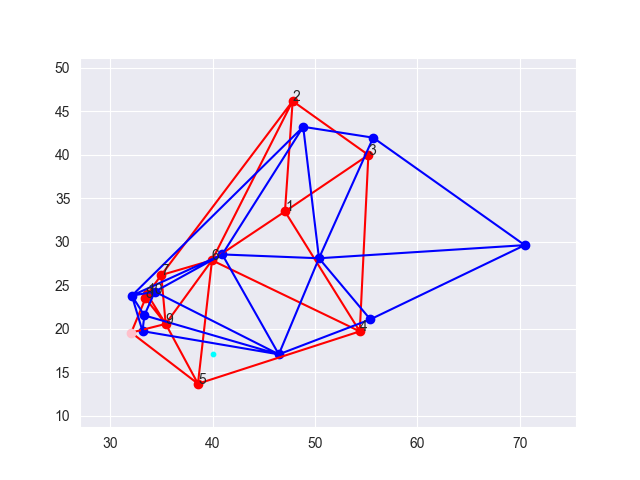

In [73]:
play_num=97
# New args include_trajectories and triangulate
anim = Animation(w1data, play_num).animate(include_trajectories=False, triangulate=True, calc_passes=True)
path = f'gifs/{play_num}.gif'
writergif = animation.PillowWriter(fps=10)
anim.save(path, writer=writergif)


In [74]:
file = open(path , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=500,
    height=500)
display.display(progress)

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00\xea\xea\xf1\xfe\xfe\xfe\x01\x01\xfe\xfe\x00\x00\x18\x18\xfd)(…